## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Дубликаты

In [5]:
# проверим дубликаты
data.duplicated().sum()

4

In [6]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

In [7]:
data.duplicated().sum()

0

### Пропуски

In [8]:
# проверим пропуски
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски есть в столбцах: тип автомобильного кузова, тип коробки передач, модель автомобиля, тип топлива, была машина в ремонте или нет. Это все категориальные переменные. Методы заполнения пропусков, основанные на соседних строках (например, метод ближайших соседей, интерполяция, форвардная заливка), а также заполнение медианой или средним больше подходят для пропусков в численных переменных и в данном случае не сгодятся. Можно заменить все пропуски значением 'unknown', тогда мы сохраним данные о пропущенных значениях. Можно также попробовать заменить пропуски на наиболее встречающиеся в столбцах значения (мода данных).

In [9]:
data = data.fillna('unknown')

In [10]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Аномалии и выбросы

In [11]:
# посмотрим теперь аномалии в численных признаках
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


После получения общей информации по столбцам, можно сделать выводы:
- Столбец с годом регистриции автомобиля содержит аномалии (минимум 1000 год регистрации, а максимум 9999). Максимум нужно ограничить годом выгрузки данных, а минимум 1920 годом, т.к. приблизительно в это время началось массовое производство автомобилей и мы закладываем возможность того, что кто-то захотел продать свой ретроавтомобиль.
- Столбец с мощностью также имеет выбросы, которые можно проработать с помощью ящика с усами, минимум стоит ограничить 10 лошадиными силами (согласно статье о самых маломощных автомобилях https://fastmb.ru/autonews/autonews_mir/1367-samye-malomoschnye-avtomobili-top-10.html)
- Столбец с пробегом выглядит правдоподобно.
- Столбец с месяцем регистрации имеет минимум 0, его было бы корректно заменить на 1-ый месяц.
- Столбец с целевым признаком ценой имеет сомнительно низкие значения. Минимальное значение ограничим 150 евро. Максимальное значение в 20000 евро не является аномально высоким.

In [12]:
# посмотрим последнюю дату выгрузки
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [13]:
# ограничим столбец с годом регистрации
print('До ограничения:', len(data))
data = data.query('1920 < RegistrationYear <= 2016')
print('После ограничения:', len(data))

До ограничения: 354365
После ограничения: 339665


Удалим столбцы, которые не будут важны для обучения модели: DateCrawled, DateCreated, NumberOfPictures, PostalCode, LastSeen.

In [14]:
data = data.drop(['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [15]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [16]:
# приведем в порядрок нулевые значения месяца регистрации
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = 1

(0.0, 2500.0)

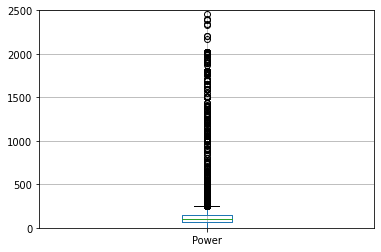

In [17]:
# построим ящик с усами для столбца с мощностью двигателя
data.boxplot(column='Power').set_ylim(0, 2500)

(-20.0, 900.0)

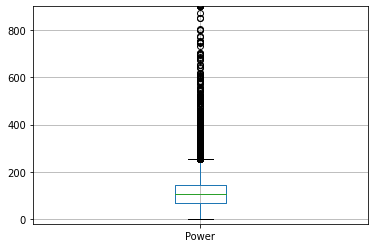

In [18]:
# построим более детальный график
data.boxplot(column='Power').set_ylim(-20, 900)

In [19]:
# посчитаем значения квартилей
q25 = data['Power'].quantile(0.25)
q75 = data['Power'].quantile(0.75)
first_part = q25-1.5*(q75-q25)
second_part = q75+1.5*(q75-q25)
print(first_part, second_part)

-42.0 254.0


In [20]:
# посмотрим сколько и какие строки попадают под условие 
data.query('255 < Power < 600')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
41,7500,sedan,2002,auto,306,e_klasse,150000,4,unknown,mercedes_benz,unknown
59,1,suv,1994,manual,286,unknown,150000,11,unknown,sonstige_autos,unknown
113,6300,sedan,2002,manual,265,golf,150000,3,petrol,volkswagen,no
125,1800,sedan,1995,auto,286,7er,150000,12,petrol,bmw,yes
172,19750,convertible,2006,manual,305,mustang,50000,7,petrol,ford,no
...,...,...,...,...,...,...,...,...,...,...,...
354191,14000,coupe,2007,manual,264,other,80000,6,petrol,opel,no
354277,6500,sedan,1993,auto,286,5er,150000,1,petrol,bmw,no
354302,16999,wagon,2008,auto,269,a6,150000,7,gasoline,audi,no
354333,11500,sedan,2004,auto,445,7er,125000,1,petrol,bmw,unknown


In [21]:
data.query('Power > 600')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
1816,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no
2102,0,sedan,1999,unknown,1799,vectra,150000,1,petrol,opel,yes
4060,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no
5328,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,unknown
6296,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes
...,...,...,...,...,...,...,...,...,...,...,...
348879,7500,sedan,2011,manual,1548,scenic,90000,4,petrol,renault,unknown
348964,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes
351943,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no
353629,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,unknown


На первый вгляд можно сказать, что данные о машинах с высокой мощностью ошибочны, т.к. в строках указаны мадели легковых маломощных машин (например, Citroen C2 или Toyota Corolla).
На более детальном графике видно, что после отметки в 600 л.с. встречаются лишь единичные точки. Нормальные значения мощности ограничиваются 254 л.с., но есть отбросить все, что выше нормальных значений, то пропадет около 7000 строк. Поэтому отбросим строки, в которых мощность выше 600 л.с. и ниже 10 л.с.

In [22]:
data.query('Power < 10')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,1,petrol,volkswagen,unknown
32,245,sedan,1994,unknown,0,golf,150000,2,petrol,volkswagen,no
37,1500,unknown,2016,unknown,0,kangoo,150000,1,gasoline,renault,no
40,0,unknown,1990,unknown,0,corsa,150000,1,petrol,opel,unknown
54,4700,wagon,2005,manual,0,signum,150000,1,unknown,opel,no
...,...,...,...,...,...,...,...,...,...,...,...
354342,2600,unknown,2005,auto,0,c_klasse,150000,9,unknown,mercedes_benz,unknown
354356,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no
354359,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354360,0,unknown,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes


In [23]:
print('До ограничения:', len(data))
data = data.query('10 < Power < 600')
print('После ограничения:', len(data))

До ограничения: 339665
После ограничения: 302720


In [24]:
# удалим сомнительно низкие значения в столбце с ценой
print('До ограничения:', len(data))
data = data[data['Price'] >= 150]
print('После ограничения:', len(data))

До ограничения: 302720
После ограничения: 294196


In [25]:
# проверим матрицу корреляции
data.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
Price,1.000000,0.481529,0.507643,-0.389875,0.059214
RegistrationYear,0.481529,1.000000,0.135087,-0.289688,0.040153
Power,0.507643,0.135087,1.000000,0.106214,0.038313
Kilometer,-0.389875,-0.289688,0.106214,1.000000,-0.011750
RegistrationMonth,0.059214,0.040153,0.038313,-0.011750,1.000000


### Вывод

Была произведена предобработка данных: удалены дубликаты, заполненые пропуски, а также удалены аномалии. Согласно матрице корреляций, наибольшее влияние на цену оказывают мощность и год регистрации автомобиля.

In [26]:
#КОД РЕВЬЮЕРА

data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth
count,294196.000000,294196.000000,294196.000000,294196.000000,294196.000000
mean,4890.455071,2002.848621,120.866881,128288.131042,6.063648
std,4611.292837,6.524095,53.719391,36706.053589,3.485809
min,150.000000,1923.000000,11.000000,5000.000000,1.000000
25%,1350.000000,1999.000000,77.000000,125000.000000,3.000000
50%,3200.000000,2003.000000,112.000000,150000.000000,6.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000
max,20000.000000,2016.000000,585.000000,150000.000000,12.000000


## Обучение моделей

### Подготовка признаков

In [27]:
# закодируем категориальные признаки методом прямого кодирования
data_ohe = pd.get_dummies(data, drop_first=True)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
1,18300,2011,190,125000,5,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163,125000,8,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,6,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,7,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,10,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
# подготовим обучающую и тестовую выборки для закодированных данных
target_ohe = data_ohe['Price']
features_ohe = data_ohe.drop('Price', axis=1)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.4, random_state=12345)

features_train_ohe.shape, features_test_ohe.shape, target_train_ohe.shape, target_test_ohe.shape

((176517, 311), (117679, 311), (176517,), (117679,))

In [29]:
# подготовим обучающую и тестовую выборку для исходных данных
target = data['Price']
features = data.drop('Price', axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_train.shape, features_test.shape, target_train.shape, target_test.shape

((176517, 10), (117679, 10), (176517,), (117679,))

In [30]:
# подготовим обучающую и тестовую выборку для модели LightGBM
light_data = data.copy()
light_data = light_data.astype({"VehicleType":'category',
                                  "Gearbox":'category',
                                  "Model":'category',
                                  "FuelType":'category',
                                  "Brand":'category',
                                  "NotRepaired":'category'})
print(light_data.info())

target_light = light_data['Price']
features_light = light_data.drop('Price', axis=1)

features_train_light, features_test_light, target_train_light, target_test_light = train_test_split(
    features_light, target_light, test_size=0.4, random_state=12345)

features_train_light.shape, features_test_light.shape, target_train_light.shape, target_test_light.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294196 entries, 1 to 354364
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Price              294196 non-null  int64   
 1   VehicleType        294196 non-null  category
 2   RegistrationYear   294196 non-null  int64   
 3   Gearbox            294196 non-null  category
 4   Power              294196 non-null  int64   
 5   Model              294196 non-null  category
 6   Kilometer          294196 non-null  int64   
 7   RegistrationMonth  294196 non-null  int64   
 8   FuelType           294196 non-null  category
 9   Brand              294196 non-null  category
 10  NotRepaired        294196 non-null  category
dtypes: category(6), int64(5)
memory usage: 15.4 MB
None


((176517, 10), (117679, 10), (176517,), (117679,))

### Решающее дерево

In [31]:
%%time

# подберем лучшие параметры с помощью поиска по сетке
model_dt = DecisionTreeRegressor()
parametrs = {'max_depth': range (1,15)}
grid_dt = GridSearchCV(model_dt, parametrs, cv=5)
grid_dt.fit(features_train_ohe, target_train_ohe)
grid_dt.best_params_

CPU times: user 2min 20s, sys: 14.7 s, total: 2min 35s
Wall time: 2min 35s


{'max_depth': 14}

In [32]:
%%time

# инициализируем модель с наилучшими гиперпараметрами
model_dt = DecisionTreeRegressor(random_state = 12345, max_depth = 14)
model_dt.fit(features_train_ohe, target_train_ohe)

CPU times: user 4.09 s, sys: 164 ms, total: 4.26 s
Wall time: 4.27 s


DecisionTreeRegressor(max_depth=14, random_state=12345)

In [33]:
%%time

# посчитаем время предсказания модели
predictions_dt = model_dt.predict(features_test_ohe)
rmse_dt = mean_squared_error(target_test_ohe, predictions_dt, squared=False)
print('RMSE модели Решающее дерево:', rmse_dt)

RMSE модели Решающее дерево: 1875.0095193815469
CPU times: user 124 ms, sys: 108 ms, total: 232 ms
Wall time: 236 ms


### Случайный лес

In [34]:
#%%time

#model_rf = RandomForestRegressor()
#parametrs = {'n_estimators': [1, 100], 'max_depth': [1, 15]}
#grid_rf = GridSearchCV(model_rf, parametrs, cv=5)
#grid_rf.fit(features_train_ohe, target_train_ohe)
#grid_rf.best_params_

In [35]:
%%time

# инициализируем модель с наилучшими гиперпараметрами 'max_depth': 15, 'n_estimators': 100
model_rf = RandomForestRegressor(random_state=12345, n_estimators = 100, max_depth = 15)
model_rf.fit(features_train_ohe, target_train_ohe)

CPU times: user 4min 40s, sys: 602 ms, total: 4min 41s
Wall time: 4min 41s


RandomForestRegressor(max_depth=15, random_state=12345)

In [36]:
%%time

# посчитаем время предсказания модели
predictions_rf = model_rf.predict(features_test_ohe)
rmse_rf = mean_squared_error(target_test_ohe, predictions_rf, squared=False)
print('RMSE модели Случайный лес:', rmse_rf)

RMSE модели Случайный лес: 1655.5151134871637
CPU times: user 2.28 s, sys: 128 ms, total: 2.4 s
Wall time: 2.41 s


### Catboost

In [37]:
%%time

model_cat = CatBoostRegressor(loss_function="RMSE")

parametrs = {'iterations': [50],
             'depth': [5, 10],
             'learning_rate': [0.1, 1]}

cat_features = ["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]

grid_cat = model_cat.grid_search(parametrs, 
                                 Pool(features_train, target_train, cat_features = cat_features),
                                 cv=3,
                                 verbose=10,
                                 plot=False)

0:	learn: 6162.9757954	test: 6206.9604847	best: 6206.9604847 (0)	total: 119ms	remaining: 5.82s
1:	learn: 5677.0327994	test: 5716.5726254	best: 5716.5726254 (1)	total: 185ms	remaining: 4.45s
2:	learn: 5246.9611469	test: 5281.4073072	best: 5281.4073072 (2)	total: 239ms	remaining: 3.75s
3:	learn: 4868.1017831	test: 4897.8778130	best: 4897.8778130 (3)	total: 298ms	remaining: 3.42s
4:	learn: 4526.4791838	test: 4551.7231691	best: 4551.7231691 (4)	total: 354ms	remaining: 3.18s
5:	learn: 4223.9491761	test: 4244.7290522	best: 4244.7290522 (5)	total: 426ms	remaining: 3.13s
6:	learn: 3960.4052968	test: 3977.8110319	best: 3977.8110319 (6)	total: 474ms	remaining: 2.91s
7:	learn: 3719.2069875	test: 3732.9763521	best: 3732.9763521 (7)	total: 526ms	remaining: 2.76s
8:	learn: 3514.2721445	test: 3523.7850614	best: 3523.7850614 (8)	total: 574ms	remaining: 2.62s
9:	learn: 3337.5398881	test: 3344.2394891	best: 3344.2394891 (9)	total: 623ms	remaining: 2.49s
10:	learn: 3181.4102615	test: 3183.5166451	best: 3

In [38]:
grid_cat['params']

{'depth': 10, 'learning_rate': 1, 'iterations': 50}

In [39]:
%%time

model_cat = CatBoostRegressor(loss_function="RMSE", iterations=50, depth=10, learning_rate=1)
cat_features = ["VehicleType", "Gearbox", "Model", "FuelType", "Brand", "NotRepaired"]
model_cat.fit(features_train, target_train, cat_features=cat_features, verbose=10) 

0:	learn: 2408.0879161	total: 110ms	remaining: 5.41s
10:	learn: 1712.9879973	total: 1.16s	remaining: 4.11s
20:	learn: 1608.4054038	total: 2.22s	remaining: 3.06s
30:	learn: 1544.4808552	total: 3.3s	remaining: 2.02s
40:	learn: 1494.8086374	total: 4.34s	remaining: 954ms
49:	learn: 1461.1517394	total: 5.28s	remaining: 0us
CPU times: user 5.57 s, sys: 15.4 ms, total: 5.59 s
Wall time: 6.2 s


In [40]:
%%time

predictions_cat = model_cat.predict(features_test)
rmse_cat = mean_squared_error(target_test, predictions_cat, squared=False)
print('RMSE модели CatBoost:', rmse_cat)

RMSE модели CatBoost: 1645.9548219051148
CPU times: user 155 ms, sys: 3.81 ms, total: 159 ms
Wall time: 163 ms


### Light GBM

In [41]:
%%time

lgb_reg = lgb.LGBMRegressor()
parameters = {'n_estimators': [5, 50],
             'max_depth': [5, 10],
             'learning_rate': [0.1, 1]}

grid_lgb = GridSearchCV(lgb_reg, parameters, cv=5)
grid_lgb.fit(features_train_light, target_train_light)
grid_lgb.best_params_

CPU times: user 1min 4s, sys: 0 ns, total: 1min 4s
Wall time: 1min 5s


{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50}

In [42]:
%%time

lgb_train = lgb.Dataset(features_train_light, label = target_train_light)
parameters_light = {'max_depth':10, 'learning_rate':0.1, 'n_estimators':50}
model_lgb = lgb.train(parameters_light, lgb_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.095136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 645
[LightGBM] [Info] Number of data points in the train set: 176517, number of used features: 10
[LightGBM] [Info] Start training from score 4888.240855
CPU times: user 2.86 s, sys: 12.7 ms, total: 2.88 s
Wall time: 2.9 s


In [43]:
%%time

predictions_lgb = model_lgb.predict(features_test_light)
rmse_lgb = mean_squared_error(target_test_light, predictions_lgb, squared=False)
print('RMSE модели LightGBM:', rmse_lgb)

RMSE модели LightGBM: 1648.6162533934082
CPU times: user 577 ms, sys: 803 µs, total: 578 ms
Wall time: 600 ms


## Анализ моделей

In [44]:
index = ['Решающее дерево', 'Случайный лес', 'Catboost', 'LightGBM']
columns = ['качество предсказания', 'скорость предсказания, сек', 'время обучения, сек']
val = [[rmse_dt, 0.237, 4.34], 
         [rmse_rf, 2.53, 290],
         [rmse_cat, 0.178, 6.84],
         [rmse_lgb, 0.578, 2.99]]
final = pd.DataFrame(index = index, columns=columns, data=val)
final

,качество предсказания,"скорость предсказания, сек","время обучения, сек"
Решающее дерево,1875.009519,0.237,4.34
Случайный лес,1655.515113,2.530,290.00
Catboost,1645.954822,0.178,6.84
LightGBM,1648.616253,0.578,2.99


По условию задачи необходимо выбрать модель, руководствуясь следующими характеристиками:
- качество предсказания;
- скорость предсказания;
- время обучения.

Исходя из этого, наиболее высокое качество показали модели CatBoost, LightGBM и Случайный лес.
По скорости предсказания наиболее быстрыми были CatBoost, Решающее дерево и LightGBM.
По времени обучения наилучший результат показали: LightGBM, Решающее дерево и CatBoost.
Таким образом, в двух из трех характеристик модель CatBoost показала лучшие результаты, следовательно она подойдет лучше всего.